# Introduction

In this test notebook we will test the classification accuracy we can achieve for the AG News Subset by using high quality but standard LLM's.

By crafting a prompt with few shot classification examples and specifying the use of structured outputs we use the LLM's as classifiers.

Note that the prompt could be specified in many ways and some might achieve a slightly higher average classification accuracy.

In [16]:
# Import Modules
import instructor
from collections import Counter
from datasets import load_dataset
from openai import OpenAI
from pprint import pprint
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm
from typing import Literal

# Plot
import matplotlib.pyplot as plt

## Dataset and Labels

In [17]:
# Load AG News dataset
dataset = load_dataset("ag_news")

# Convert to Pandas DataFrame
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Class Labels
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
df_train['label_name'] = df_train['label'].apply(lambda x: class_names[x])
df_test['label_name'] = df_test['label'].apply(lambda x: class_names[x])

# Dataset Sizes
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 120000
Test size: 7600


## Setup Instructor and LLM

In [18]:
# Specify Structured Output
# Only allow Class Names for AG News Subset. Only allow a single value from the fixed set
class Category(BaseModel):
    category: Literal['World', 'Sports', 'Business', 'Sci/Tech'] = Field(
        ...,
        description = "Choose exactly one category of: 'World', 'Sports', 'Business' or 'Sci/Tech'"
    )

In [19]:
# Create Client
client = instructor.from_openai(OpenAI(base_url = "http://localhost:11434/v1", api_key = "ollama"), mode = instructor.Mode.JSON)

## Classify AG News Subset

In [20]:
# Subsample
#df_test = df_test.sample(n = 1000)

In [21]:
# In Context Examples - 1 per category
SEED = 42
examples = {label: df_train.loc[df_train["label_name"].eq(label), "text"].sample(1, random_state=SEED).iloc[0]  for label in class_names}

# Format
fewshot_text = "\n\n".join([f"""Category: {label}\nNews Article: {examples[label]}""" for label in class_names])

# Summary
print(fewshot_text)

Category: World
News Article: Explosion Rocks Baghdad Neighborhood BAGHDAD, Iraq, August 24 -- A car bomb exploded near the gate of a US-funded Iraqi television network in Baghdad on Tuesday, killing at least two people and wounding two others, authorities and witnesses said.

Category: Sports
News Article: Second Andre win in a row boosts US gold medal hopes Andre Dirrell, fighting with a tattoo of his grandfather #39;s face on his back, assured the United States of at least two boxing medals Wednesday by narrowly beating Cuba #39;s Yordani Despaigne to advance to the Olympic middleweight semifinals.

Category: Business
News Article: US house sales fall in July Sales of non-new houses in the US fell last month but still exceeded analyst forecasts.

Category: Sci/Tech
News Article: Gartner optimistic about chip numbers But that optimism isn #39;t matched by Infineon, which said that while the market worldwide remains buoyant, the US is a special case and cautioned that growth might not

In [22]:
# Create Message
def create_message(text):
    prompt = f"""
You are a precise news-topic classifier. Choose exactly one category from:
World, Sports, Business, Sci/Tech.

Here are four labeled examples (one per category):
{fewshot_text}

Now classify the following news article.

News Article:
{text}
"""
    
    message = [{
                    "role": "system", 
                    "content": "You are a precise news-topic classifier. Classify each article into exactly one of: World, Sports, Business, Sci/Tech. "
               },
               {
                   "role": "user", 
                   "content": prompt
               }]
    
    return message

In [23]:
# Example
pprint(create_message(df_train.iloc[0]['text']))

[{'content': 'You are a precise news-topic classifier. Classify each article '
             'into exactly one of: World, Sports, Business, Sci/Tech. ',
  'role': 'system'},
 {'content': '\n'
             'You are a precise news-topic classifier. Choose exactly one '
             'category from:\n'
             'World, Sports, Business, Sci/Tech.\n'
             '\n'
             'Here are four labeled examples (one per category):\n'
             'Category: World\n'
             'News Article: Explosion Rocks Baghdad Neighborhood BAGHDAD, '
             'Iraq, August 24 -- A car bomb exploded near the gate of a '
             'US-funded Iraqi television network in Baghdad on Tuesday, '
             'killing at least two people and wounding two others, authorities '
             'and witnesses said.\n'
             '\n'
             'Category: Sports\n'
             'News Article: Second Andre win in a row boosts US gold medal '
             'hopes Andre Dirrell, fighting with a tattoo o

## Evaluate Gemma3 12B LLM

In [24]:
# PlaceHolders
y_true, y_pred = [], []

# Classification Loops
for index, row in tqdm(df_test.iterrows(), total = df_test.shape[0]):
    # Get Text and GT label
    text = row['text']
    gt_label = row['label_name']


    # Call LLM
    response = client.chat.completions.create(model = "gemma3:12b",
                                              messages = create_message(text),
                                              response_model = Category,
                                              temperature = 0.01,
                                              top_p = 0.98,
                                              strict = True,
                                              max_retries = 10)

    # !! DEBUG Only Print Output
    #print(resp.model_dump_json(indent=2))
    #print(f"GT Label: {gt_label}     Model Label: {resp.category}")

    # Store Predictions
    y_true.append(gt_label)
    y_pred.append(response.category)

  0%|          | 0/7600 [00:00<?, ?it/s]


Overall accuracy: 85.03%
Per-class accuracy:
  World   : 89.16%
  Sports  : 97.21%
  Business: 90.11%
  Sci/Tech: 63.63%


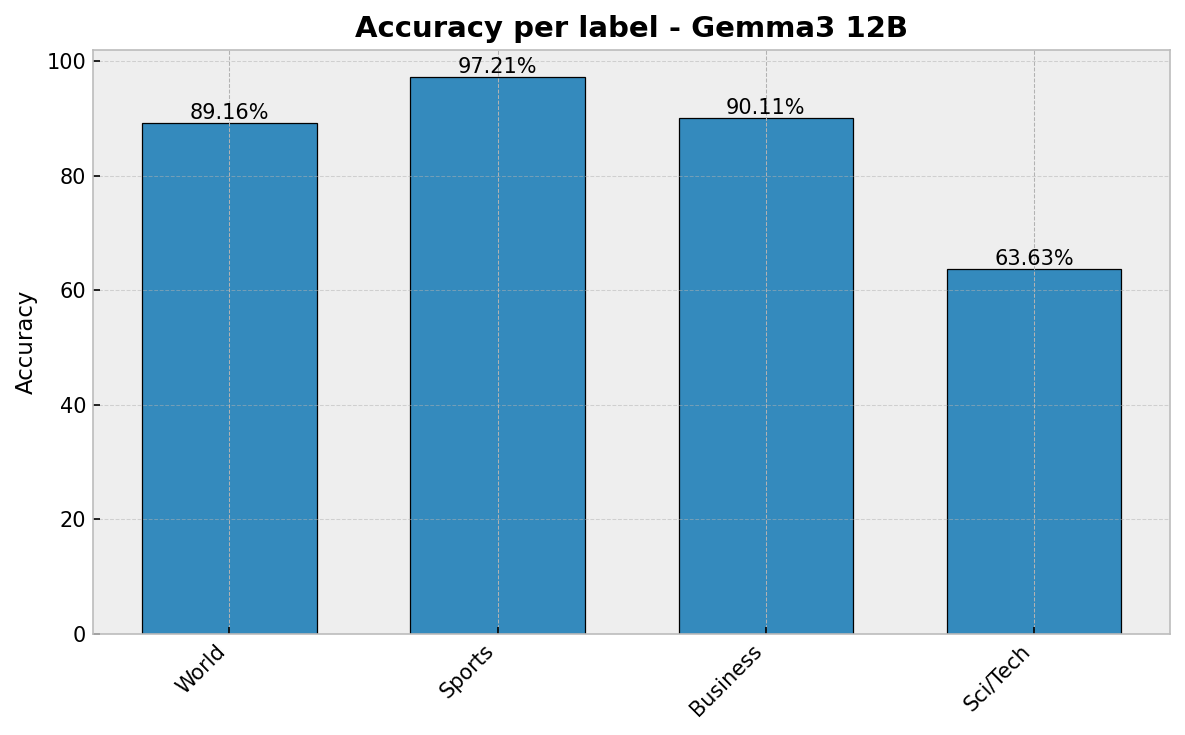

In [25]:
# Average and per Class Accuracy
total = Counter(y_true)
correct = Counter(t for t, p in zip(y_true, y_pred) if t == p)

overall_acc = sum(correct.values()) / len(y_true)
print("\nOverall accuracy: {:.2%}".format(overall_acc))

# Per-class accuracy list (for plotting)
acc_per_class = [correct[c] / total[c] * 100 for c in class_names]

print("Per-class accuracy:")
for c, a in zip(class_names, acc_per_class):
    print(f"  {c:8}: {a:.2f}%")

# Plotting
plt.style.use("bmh")
plt.figure(figsize = (8, 5), dpi = 150)
bars = plt.bar(range(len(class_names)), acc_per_class, width = 0.65, edgecolor = "black", linewidth = 0.6)
plt.xticks(range(len(class_names)), class_names, rotation = 45, ha = "right")
plt.ylabel("Accuracy", fontsize = 11)
plt.title("Accuracy per label - Gemma3 12B", fontsize = 14, weight = "bold")
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)

# Annotate bars
for i, a in enumerate(acc_per_class):
    plt.text(i, a + 0.02, f"{a:.2f}%", ha = "center", va = "bottom", fontsize = 10)

# Final Plot
plt.tight_layout()
plt.show()

## Evaluate Gemma3 27B LLM

In [26]:
# PlaceHolders
y_true, y_pred = [], []

# Classification Loops
for index, row in tqdm(df_test.iterrows(), total = df_test.shape[0]):
    # Get Text and GT label
    text = row['text']
    gt_label = row['label_name']


    # Call LLM
    response = client.chat.completions.create(model = "gemma3:27b",
                                              messages = create_message(text),
                                              response_model = Category,
                                              temperature = 0.01,
                                              top_p = 0.98,
                                              strict = True,
                                              max_retries = 10)

    # !! DEBUG Only Print Output
    #print(resp.model_dump_json(indent=2))
    #print(f"GT Label: {gt_label}     Model Label: {resp.category}")

    # Store Predictions
    y_true.append(gt_label)
    y_pred.append(response.category)

  0%|          | 0/7600 [00:00<?, ?it/s]


Overall accuracy: 86.57%
Per-class accuracy:
  World   : 87.16%
  Sports  : 97.47%
  Business: 92.21%
  Sci/Tech: 69.42%


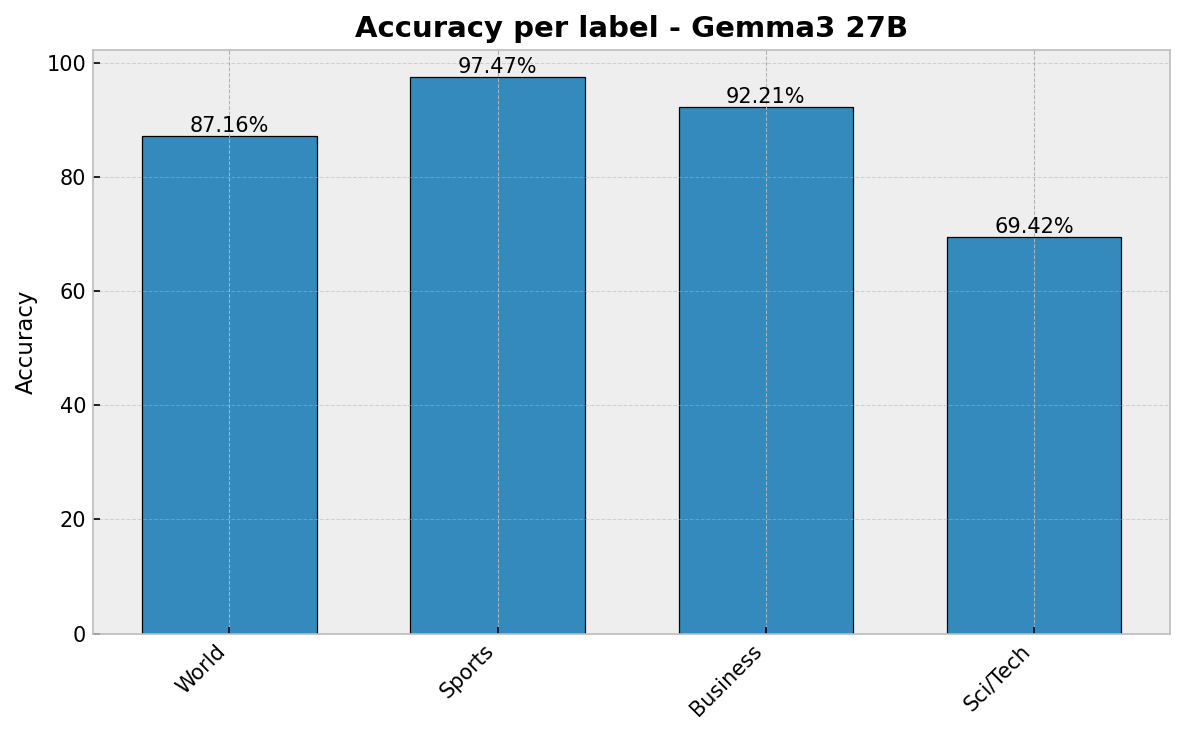

In [27]:
# Average and per Class Accuracy
total = Counter(y_true)
correct = Counter(t for t, p in zip(y_true, y_pred) if t == p)

overall_acc = sum(correct.values()) / len(y_true)
print("\nOverall accuracy: {:.2%}".format(overall_acc))

# Per-class accuracy list (for plotting)
acc_per_class = [correct[c] / total[c] * 100 for c in class_names]

print("Per-class accuracy:")
for c, a in zip(class_names, acc_per_class):
    print(f"  {c:8}: {a:.2f}%")

# Plotting
plt.style.use("bmh")
plt.figure(figsize = (8, 5), dpi = 150)
bars = plt.bar(range(len(class_names)), acc_per_class, width = 0.65, edgecolor = "black", linewidth = 0.6)
plt.xticks(range(len(class_names)), class_names, rotation = 45, ha = "right")
plt.ylabel("Accuracy", fontsize = 11)
plt.title("Accuracy per label - Gemma3 27B", fontsize = 14, weight = "bold")
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)

# Annotate bars
for i, a in enumerate(acc_per_class):
    plt.text(i, a + 0.02, f"{a:.2f}%", ha = "center", va = "bottom", fontsize = 10)

# Final Plot
plt.tight_layout()
plt.show()

## Conclusion

In this test notebook we used 2 high quality all-round LLM's. With no modifications - besides specific prompting and using structured outputs - they deliver a high accuracy classification but lag behind the K-NN algorithm and the Finetuned SLM.

When using Gemma3-12B as a classifier we achieve an average overall classification accuracy of: **84.57%** (Based on multiple test runs with different seeds: 85.01%, 85.03%, 84.89%, 83.33%)

When using Gemma3-27B as a classifier we achieve an average overall classification accuracy of: **86.66%** (Based on multiple test runs with different seeds: 86.57%, 86.39%, 86.24%, 87.42%)